# Toyexample simulation
This notebook shows a toyexample simulation of the problem and solution for pose estimation of symmetric objects covered in the paper Richter-Klug, Frese, ..... The toy example is estimating angle of a rotating disc from a sideward looking 1D-camera, where the texture on the disc has nSym-fold symmetry. A CNN learning this mapping image --> angle has problems because it is required to learn a discontinuous function. This is true, even though the loss respects symmetry and is alway a minimum over all symmetric equivalent. 

This also holds if the angle is represented as a unit vector, but not if as proposed in the paper, the angle is represented as a unit vector where rotating this vector by 360° actually codes for a 360°/nSym angle, i.e. of cycle of the symmetry.

Apart from the problem of directly predicting the angle, also the problem of predicting a point in object coordinates per pixel is analyzed. The same holds for the regular representation but not for the representation proposed in the paper.

In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import path

In [2]:
# Constants
nSym = 6 # Example works with 6-fold symmetry
aSym= 2*math.pi/nSym # symmetric angle
imageSize = 64 # Nr. of pixels in the 1-D image
nModels = 11 # nModels models of every type are trained, then the median model is taken
epochs = 500 # Nr. of epochs to train each model

In [3]:
def atan2 (T,keepdims=False):
    '''A version of atan2 that takes a tensor with the last dimension 2 and applies atan2 to it. If
    keepdims=False the result is returned as a tensor with one dimension less, otherwise with last
    dimension 1.'''
    result = np.arctan2(T[...,1], T[...,0])
    if keepdims: result = np.expand_dims(result, axis=-1)
    return result 
    
def textureF (alpha):
    '''Returns the brightness value of the disc perimeter at an angle of alpha in disc-coordinates.'''
    s = np.sin (alpha*nSym/2)
    return (1+np.cos(s*10))/2

def angleOfRay (rayOX, rayOY, rayVX, rayVY):
    '''Returns the angle on the disc where the disc border intersects the ray passed in the parameter.
    If there is no intersection it returns nan. Can be used with tensors.'''
    vL = np.hypot(rayVX, rayVY)
    rayVX /= vL
    rayVY /= vL
    pv = rayOX*rayVX+rayOY*rayVY
    radiant = pv**2-rayOX**2-rayOY**2+1
    lbd = -pv-np.sqrt(radiant) # NaN if negative. This means ray does not hit disc.
    pX = rayOX+lbd*rayVX
    pY = rayOY+lbd*rayVY
    #assert (math.hypot(pX,pY)-1)<0.0001
    return np.arctan2(pY, pX)

def rayOfPixel (x):
    '''Returns the ray originating from pixel x as a 4-tuple (x0,y0,xdir,ydir).'''
    # the disc has center at 0,0 and radius 0.
    camX = 2 # the camera is a (0,camX) looking leftward    
    f    = 40 # effective focal lenth
    return camX, 0, -f, x-imageSize/2

def angleOfPixel (x):
    '''Returns the angle on the disc where the ray correspoding to pixel x hits the disc. The results
    assumes the disc is rotated at angle 0, any rotation angle of the disc itself must be added.'''
    angle = angleOfRay (*rayOfPixel(x))
    return angle

def pixel (x, alpha):
    '''Returns the brightness of pixel x of the image when the disc is rotated by alpha. Can handle tensors.'''
    angle = angleOfPixel (x)
    result = textureF(angle+alpha)
    result[np.isnan(result)]=0.5
    return result

def image (alpha):
    '''Returns the image the 1-D camera takes when the disc has angle alpha. alpha can be a tensor.
    The image has a final channel dimension. So overall the dimension are alpha.shape, imageSize, 1.'''
    xs, alphas = np.meshgrid(np.array(range(0,imageSize)), alpha)
    img = pixel(xs, alphas)
    return np.expand_dims(img, -1) # Add channeldimension 1

def pOAngleImage (alpha):
    xs, alphas = np.meshgrid(np.array(range(0,imageSize)), alpha)
    pOAngles = angleOfPixel (xs)+alphas
    return pOAngles
   
def pOImage (alpha, nanToZero=True, angleFactor=1):
    '''Returns an image of object points corresponding to image (alpha). An object point is the 2D coordinates
    of the point of the disc seen at a pixel expressed in disc-coordinates. Overall the dimension are alpha.shape, imageSize, 2.
    If nanToZero=True is given, pixel outside the disc are not nan but (0,0). If nanToZero is a float, pixel outside the
    disc are map to a point nanToZero away from the camera. The angles are multiplied by angleFactor
    before computing the vector.'''
    xs, alphas = np.meshgrid(np.array(range(0,imageSize)), alpha)
    pOAngles = angleOfPixel (xs)+alphas
    result = np.stack([np.cos(pOAngles*angleFactor), np.sin(pOAngles*angleFactor)],axis=-1)
    mask = np.isnan(result[...,0])
    if nanToZero==True: result[mask,:] = np.array([0,0])
    if isinstance(nanToZero,int) or isinstance(nanToZero,float):
        rays = np.array([rayOfPixel(x) for x in range(0,imageSize)])
        rays = rays[:,0:2] + nanToZero*rays[:,2:4]/np.linalg.norm(rays[:,2:4], axis=-1,keepdims=True)
        rays = np.broadcast_to(rays, result.shape)
        result[mask,:] = rays[mask,:]
    return result

def imageOfPO (pOImage):
    '''Applies the discs texture to an image of object points for visualization purposes'''
    img = textureF (atan2(pOImage))
    img[np.isnan(img)]=0.5
    return np.expand_dims(img, -1) # Add channeldimension 1

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


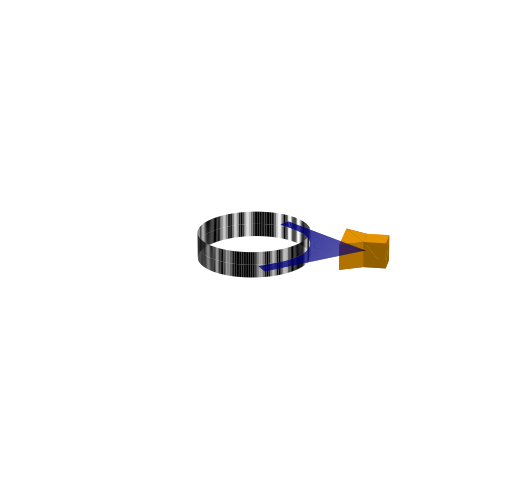

In [4]:
def plotSetup():
    '''Shows the setup with a rotating disc and the camera as a 3d plot.'''
    # Make a 3D drawing of the setup
    fig = plt.figure(figsize=(9,9))
    ax = fig.gca(projection='3d')
    ax._axis3don = False
    #ax.set_xlim(-1.2, 3*2.4+1.2)
    #ax.set_ylim(-1.2, 1.2)
    #ax.set_zlim(-1, 1)
    ax.view_init(elev=20, azim=-80)
    # Dummy plot to make the bounding box cubic
    dummyPts = np.array([[-1,0,0], [1,0,0], [0,-1,0], [0,1,0], [0,0,-1], [0,0,1]])
    dummyPts*=2
    ax.plot(dummyPts[:,0], dummyPts[:,1], dummyPts[:,2],'w')

    # Disc-Perimeter (overwrites viewing plage)
    alpha = np.linspace(0,2*math.pi,600)
    h = np.array([-0.2,0,+0.2])
    alpha, h = np.meshgrid(alpha, h, indexing='ij')
    X = np.cos(alpha)
    Y = np.sin(alpha)
    Z = h
    T = textureF(alpha)
    Ones = np.broadcast_to(1,T.shape)
    C = np.stack([T,T,T,Ones],axis=-1)
    ax.plot_surface(X, Y, Z, facecolors=C, linewidth=0, rcount=200, antialiased=True)

        # Viewing plane
    camOrigin = np.expand_dims(np.array(rayOfPixel(0)[0:2]),axis=0)
    pOI = np.concatenate([camOrigin,pOImage (0, nanToZero=2)[0]])
    X = pOI[:,0]
    Y = pOI[:,1]
    Z = np.zeros_like (X)
    triangles = [(0,i,i+1) for i in range(1,imageSize-1)]
    ax.plot_trisurf (X, Y, Z, triangles=triangles, linewidth=0, color='b') # plot_trisurf
    
    # Camera
    pts = np.array([[-1,-  1,-0.5], [-1,-  1, 0.5], # 0  1
                    [ 0,-0.5,-0.5], [ 0,-0.5, 0.5], # 2  3
                    [ 1,-0.5,-0.5], [ 1,-0.5, 0.5], # 4  5
                    [-1,   1,-0.5], [-1,   1, 0.5], # 6  7
                    [ 0, 0.5,-0.5], [ 0, 0.5, 0.5], # 8  9
                    [ 1, 0.5,-0.5], [ 1, 0.5, 0.5]]) #9 10
    triangles = [(2,0,6), (8,2,6), (4,2,8), (4,8,10), # bottom face
                 (1,3,7), (3,9,7), (3,5,9), (9,5,11),  # top face
                 (6,0,7), (0,1,7),              # front face
                 (8,6,9), (7,9,6), # side faces
                 (8,10,11), (11,9,8), # side face
                 (4,11,5), (11,4,10), # back face
                 (4,2,3), (4,3,5), # other side faces
                 (2,0,1), (2,1,3) # other side faces
                ] 
    pts = np.array((camOrigin[0,0], camOrigin[0,1], 0)) + 0.4*pts
    ax.plot_trisurf (pts[:,0], pts[:,1], pts[:,2], triangles = triangles, linewidth=0, color='orange')
    plt.savefig('toyexample-setup.png', dpi=400)
    plt.show()
    
plotSetup()

In [5]:
gtAlpha = np.arange(0,2*math.pi,2*math.pi/360)
imgData = image (gtAlpha)

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


In [6]:
len(gtAlpha)

360

In [7]:
def plotImages (alpha, images, vmin=0, vmax=1, xlim=None, fname=None):
    '''Plots a 1D array of 1D-images, where each column is an image. The corresponding alphas values are shown
    on the x-axis.'''
    plt.tight_layout()
    fig, ax = plt.subplots (1, 1, figsize=(6,3))
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

    if xlim: 
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(0,aSym+0.1)
    ax.set_ylim(0,64)
    iT = np.transpose(images[:,:,0])
    extent = (np.min(alpha),np.max(alpha),0,imageSize-1)
    ax.imshow(iT, interpolation='bilinear', cmap='gray', aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
    for i in range(3):
        ax.axvline (i*aSym, color='cyan')
    fig.show()
    if fname: fig.savefig(fname, bbox_inches='tight')
    
def plotError (alpha, error, **kwargs):
    '''Same as plotImage but with a colormap mapping 0-->white, 0.2-->black'''
    plotImages (angleP, 0.2-np.expand_dims(error, axis=-1), vmax=0.2, **kwargs)
    
def plotAngles (alpha, angles, **kwargs):
    '''Plots a 1D array of 1D-images, where each column is an array of angles plotted as itensities.'''
    valuesP = atan2(angles)%aSym
    valuesP = np.expand_dims(valuesP,-1)
    plotImages(alpha, valuesP)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 432x288 with 0 Axes>

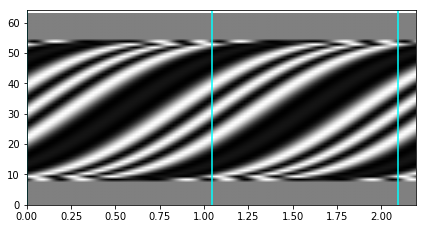

In [8]:
plotImages(gtAlpha, imgData, xlim=(0,2*aSym+0.1), fname="toyexample-texture.pdf")
# The columns of this image shows the 1D-pictures of the rotating disc, where the x-axis is the angle of rotation. 
# The vertical line marks one round of symmetry.

In [9]:
def aePAngle (y_true, y_pred):
    '''Absolute difference in two tensors of angles respecting symmetry'''
    diff = (y_true-y_pred) % aSym 
    diff = tf.minimum (diff, aSym-diff)
    return diff
    
def maePAngle (y_true, y_pred):
    '''Mean absolute error respecting symmetry for angles with 2pi/nSym symmetry.'''
    diff = aePAngle (y_true, y_pred)
    axes = tuple(range(1,len(y_true.shape)))
    return tf.reduce_mean(diff, axis=axes)

In [10]:
def rot(angle):
    return np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])

def rots():
    return np.array([rot(i*2*math.pi/nSym) for i in range (0, nSym)])

def mae (y_true, y_pred):
    return tf.norm(y_true-y_pred, axis=-1)
    
def maePVector (y_true, y_pred, meanOverAxesBeforeMin=()):
    '''Mean absolute error respecting symmetry for vectors with 2pi/nSym rotation symmetry. As this is about 2d 
    vectors the last dimension must be 2. Default: every vector entry takes its own minimum, no consistent choice is
    required. If axes are specified in meanOverAxesBeforeMin, than the mean over these axes is taken before the
    minimum over symmetric variants is taken. This means elements belonging together in these axes need to take
    the same choice in which symmetric variant is preferred.'''
    myRots = rots()
    rotatedP = tf.einsum('kij,...j->k...i', myRots, y_pred) #Result: Symmetries * .... * Vector
    rotatedP = tf.norm(y_true-rotatedP, axis=-1)
    axesP1   = tuple([axis+1 for axis in meanOverAxesBeforeMin])
    rotatedP = tf.reduce_mean (rotatedP, axis=axesP1)
    loss = tf.reduce_min(rotatedP, axis=0)
    return loss
    #axes = tuple(range(1,len(y_true.shape)-1))
    #return tf.reduce_mean(loss, axis=axes) # Do not average of batch (first) and vector dimension (last)
    
def maePCVector (y_true, y_pred):
    '''Mean absolute error respecting symmetry for vectors with 2pi/nSym rotation symmetry. As this is about 2d 
    vectors the last dimension must be 2. All vectors in a single sample need to choose the same symmetry base, 
    i.e. first the mean over intermediate axes (pixels) is taken, then the minimum over symmetry.'''
    axes = tuple(range(1,len(y_true.shape)-1))
    return maePVector(y_true, y_pred, axes)

In [11]:
def predict (model):
    '''Passes densely images from densely spaced angles through 
    model and returns the angles and the results (a tensor where the angles form the batch dimension)'''
    angles = np.arange(0, 2*aSym+0.1, 2*math.pi/3600)
    results = model.predict(image(angles))
    #print(results.shape)
    return angles, results

In [12]:
def plotAngular (angles, predicted, training=None, xlim=None, zoomlim=None, fname=None):
    '''Plots a result of angle estimation by an algorithms. It basically plots (with points) predicted on y and
    angles on x but adds a slanted horizontal grid and true angles with symmetry lines. If 
    training is given as (angles, values), it shows the training data on top. If xlim = (min,max) is given only
    that part on the x-axis is shown. If zoomlim is given, the given part of the x-axis is shown in a second
    plot (e.g. for magnifying a part of the curve).'''
    if training is not None: # find nearesst predicted value to training x
        hv = np.abs(np.expand_dims(angles, axis=1)-training[0])
        idx = np.argmin(hv,axis=0)
        trainY = predicted[idx]
    if xlim:
        minA, maxA = xlim
    else:
        minA = np.min(angles)
        maxA = np.max(angles)
    mask = (minA<=angles) & (angles<=maxA)
    minP = np.min(predicted[mask])
    maxP = np.max(predicted[mask])
    if training is not None:
        mask2 = (minA<=training[0]) & (training[0]<=maxA)
        minP = np.minimum(minP, np.min(training[1][mask2]))
        maxP = np.maximum(maxP, np.max(training[1][mask2]))

    minI = (minP-maxA)/aSym
    maxI = (maxP-minA)/aSym
    plt.tight_layout()
    if zoomlim:
        fig, (ax1, ax2) = plt.subplots (1, 2, sharey='all', figsize=(7,3), gridspec_kw={"width_ratios":[3,1]})
    else:
        fig, (ax1) = plt.subplots (1, 1, figsize=(6,3))
    fig.tight_layout()
    if xlim is not None: ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_ylim(minP-0.1, maxP+0.1)
    ax1.grid(axis='y')
    for i in range(nSym+1):
        ax1.axvline (aSym*i, color='cyan')
    iLo = math.floor(minI)
    iHi = math.ceil(maxI)+1
    for i in range(iLo, iHi):
        ax1.plot(angles, angles+i*aSym, color='lightgreen')
    ax1.plot(angles[mask], predicted[mask], '.', color='blue')
    if training is not None: ax1.plot(training[0], trainY, '.', color='red', zorder=2)
    ax1.legend()
    if zoomlim:
        ax2.set_xlim(zoomlim)
        ax2.grid(axis='y')
        for i in range(nSym+1):
            ax2.axvline (aSym*i, color='cyan')
        for i in range(math.floor(minI), math.ceil(maxI)+1):
            ax2.plot(angles, angles+i*aSym, color='lightgreen')
            ax2.plot(angles, predicted, '.', color='blue')
        if training is not None: ax2.plot(training[0], trainY, '.', color='red',zorder=2, markersize=12)
    fig.show()
    if fname: fig.savefig(fname, bbox_inches='tight')

W0928 10:10:30.197587 140735759434624 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

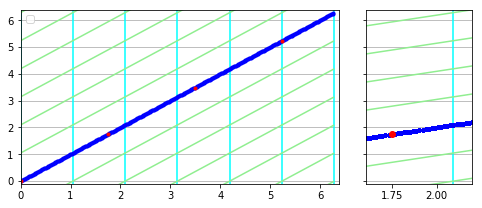

In [13]:
plotAngular (gtAlpha, gtAlpha, training = (gtAlpha[::100], gtAlpha[::100]), xlim=(0,2*math.pi+0.1), zoomlim=(1.6,2.2))

In [14]:
channels = [4, 6, 8, 8] # Nr. of channels in the different stages CURRENTLY ONLY 4 CHANNELS DUE TO BUG
def encoderStage(c, x):
    '''Adds one Conv-BN-ReLU-MaxPool stage to x with c channels. Returns the final 
    Tensor and the one before pooling (to draw shortcut connections).'''
    x   = keras.layers.Conv1D (c, 5, padding='same')(x)
    x   = keras.layers.BatchNormalization() (x)
    xSc = keras.layers.Activation('relu')(x)
    x   = keras.layers.MaxPool1D() (xSc)
    return x, xSc

def encoderFCNet (outputChannels):
    '''Creates and returns a model with a 4 stage encoder and two 
    FC layers, the last having c channels and linear activation.
    The model is not compiled yet.'''
    input = keras.layers.Input(shape=(imageSize,1))
    x = input
    for c in channels:
        x, _ = encoderStage(c, x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(4, activation='relu')(x)
    x = keras.layers.Dense(outputChannels)(x) 

    return keras.Model(inputs=input, outputs=x)

def multiTrain (singleTrain):
    '''Builds and trains several models independently and returns the one with the median loss. 
    The returned model is also saved and automatically loaded next time.
    The user must provide a function singleTrain(doTrain) that builds, initializes and trains one model
    and returns the model itself and the history object from fit. If doTrains is False singleTrain shall
    only build the model and return None as history.'''
    fname = singleTrain.__name__+"-median.h5"
    if path.exists(fname):
        print(f"Loading {fname}")
        model, _ = singleTrain(False)
        model.load_weights(fname)
    else:
        models = [] # List of (model, loss) for all the models build
        for ctr in range(nModels):
            model, hist = singleTrain(True)
            loss = hist.history["loss"][-1]
            models.append ((model, loss))
            print(loss)
        models.sort(key=lambda entry: entry[1])
        model = models[len(models)//2][0]
        model.save_weights(fname)
    return model

## Model Nr. 0: Normalized angles

In [15]:
gtNAngles = gtAlpha % aSym

In [16]:
# Model Nr. 0: Output as a normalized angle in [0..aSym]
def singleTrain0(doTrain):
    model = encoderFCNet(1) # Output as an angle
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    if doTrain:
        history = model.fit(imgData, gtNAngles, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None
    
model0 = multiTrain(singleTrain0)

Loading singleTrain0-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
W0928 10:10:31.824380 140735759434624 legend.py:1289] No handles with labels found to put in legend.


MAE (angle):0.009957919873378


<Figure size 432x288 with 0 Axes>

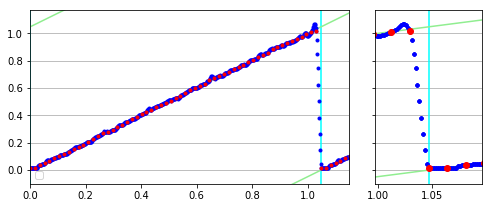

In [17]:
angleP, valuesP = predict(model0)
valuesP = valuesP [:,0]
print(f"MAE (angle):{np.mean(maePAngle(angleP, valuesP))}")
plotAngular (angleP, valuesP, training = (gtAlpha, gtNAngles), xlim=(0,aSym+0.1), zoomlim=(aSym-0.05,aSym+0.05), fname='toyexample-model0.pdf')

## Model Nr. 1 : Angles with symmetry

In [18]:
# Model Nr. 1: Output as an angle with symmetry aware loss
def singleTrain1(doTrain):
    model = encoderFCNet(1) # Output as an angle
    model.compile(loss=maePAngle, optimizer='adam', metrics=[maePAngle])
    if doTrain:
        history = model.fit(imgData, gtAlpha, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model1 = multiTrain(singleTrain1)

Loading singleTrain1-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
W0928 10:10:33.434376 140735759434624 legend.py:1289] No handles with labels found to put in legend.


MAE (angle):0.03736417285184527


<Figure size 432x288 with 0 Axes>

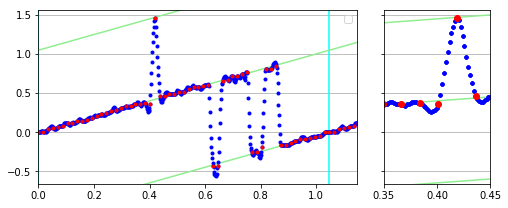

In [19]:
angleP, valuesP = predict(model1)
valuesP = valuesP [:,0]
print(f"MAE (angle):{np.mean(maePAngle(angleP, valuesP))}")
plotAngular (angleP, valuesP, training = (gtAlpha, gtAlpha), xlim=(0,aSym+0.1), zoomlim=(0.35,0.45), fname='toyexample-model1.pdf')

## Model Nr. 2: direction vectors

In [20]:
# Model Nr. 2: Output as a 2D-Vector with symmetry aware loss
def anglesToVector (angles):
    '''Returns a n*2 tensor coding the angles as 2D unit vectors'''
    return np.stack([np.cos(angles), np.sin(angles)],axis=1)
gtVector = anglesToVector (gtAlpha)

In [21]:
def singleTrain2(doTrain):
    model = encoderFCNet(2) # Output as a 2D vector
    model.compile(loss=maePVector, optimizer='adam', metrics=[maePVector])
    if doTrain:
        history = model.fit(imgData, gtVector, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model2 = multiTrain(singleTrain2)

Loading singleTrain2-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
W0928 10:10:34.914131 140735759434624 legend.py:1289] No handles with labels found to put in legend.


MAE (angle):0.0671771785382147


<Figure size 432x288 with 0 Axes>

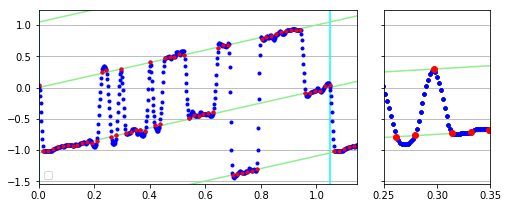

In [22]:
angleP, valuesP = predict(model2)
valuesP = atan2(valuesP)
print(f"MAE (angle):{np.mean(maePAngle(angleP, valuesP))}")
plotAngular (angleP, valuesP, training = (gtAlpha, gtAlpha), xlim=(0,aSym+0.1), zoomlim=(0.25,0.35), fname='toyexample-model2.pdf')

## Model Nr. 3: symmetry aware vector representation (proposed)

In [23]:
# Model Nr. 3: Output as a 2D-Vector symmetry aware vector, with mae loss
gtSVector = anglesToVector (nSym*gtAlpha)

def singleTrain3(doTrain):
    model = encoderFCNet(2) # Output as a 2D-vector
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    if doTrain:
        history = model.fit(imgData, gtSVector, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model3 = multiTrain(singleTrain3)

Loading singleTrain3-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
W0928 10:10:36.436264 140735759434624 legend.py:1289] No handles with labels found to put in legend.


MAE (angle):0.002044898057622201


<Figure size 432x288 with 0 Axes>

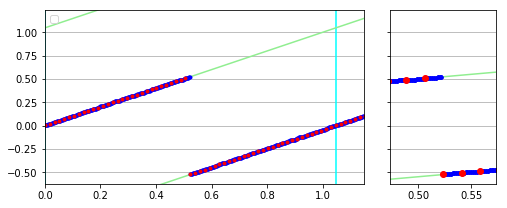

In [24]:
angleP, valuesP = predict(model3)
valuesP = atan2(valuesP)/nSym
print(f"MAE (angle):{np.mean(maePAngle(angleP, valuesP))}")
plotAngular (angleP, valuesP, training = (gtAlpha, gtAlpha), xlim=(0,aSym+0.1), zoomlim=(aSym/2-0.05, aSym/2+0.05), fname='toyexample-model3.pdf')

## Model Nr. 4: pO image with symmetry aware loss

In [25]:
gtPOData = pOImage(gtAlpha)
gtPOAlpha = pOAngleImage(gtAlpha)

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


In [26]:
def decoderStage(c, x, xSc=None, UseUpSampling=True):
    '''Adds one Concat-Conv-BN-ReLU-UpSampling stage to x with c channels. 
    sc is the shortcut from the encoder or None. Returns the final 
    tensor. If UseUpSampling=False, no upsampling will be done.'''
    if xSc is not None: x = keras.layers.Concatenate()([x, xSc])
    x   = keras.layers.Conv1D (c, 5, padding='same')(x)
    x   = keras.layers.BatchNormalization() (x)
    x   = keras.layers.Activation('relu')(x)
    if UseUpSampling: x   = keras.layers.UpSampling1D() (x)
    return x


def encoderDecoderNet (outputChannels):
    '''Creates and returns a model with a 4 stage encoder, a 4 stage
    decoder and a final Conv Layers,  
    having c channels and linear activation.
    The model is not compiled yet.'''
    input = keras.layers.Input(shape=(imageSize,1))
    x = input
    n = len(channels)
    xSc = [None]*n
    for i in range(n):
        x, xSc[i] = encoderStage(channels[i], x)
    x = decoderStage(channels[-1], x)
    for i in reversed(range(n)):
        x = decoderStage(channels[i], x, xSc[i], i>0)
    x = keras.layers.Conv1D (outputChannels, 5, padding='same')(x)

    return keras.Model(inputs=input, outputs=x)

In [27]:
def xyMaxInterpolated (l):
    '''Returns the maximum of the list l in a quadratically interpolated fashion. The return value is a pair x,y
    that corresponds to the continuous maximum around the discrete maximum.'''
    i = np.argmax(l)
    if len(l)<=2: return i, l[i]
    if i==0: i=1
    if i==len(l)-1: i=len(l)-2
    denom = l[i-1]-2*l[i]+l[i+1]
    if denom==0: return i, l[i]
    xmax = i + (l[i-1]-l[i+1])/(2*denom)
    if xmax<0: xmax=0
    if xmax>len(l)-1: xmax=len(l)-1
    ymax = l[i] - (xmax-i)*(l[i-1]-l[i+1])/2 + (xmax-i)**2*denom/2

    return xmax, ymax

def angleOfPrediction (pred, gtOutput, gtAngle, loss):
    '''Finds the angle to which pred corresponds best. loss is the loss function used for comparing.
       gtOutput[i] is the groundTruth for gtAngle[i]. The value is returned in a interpolated fashion.'''
    m = pred.shape[0] # Nr. of angles to determine
    angl = np.zeros(m)
    for i in range(m):
        l = [-np.mean(loss(pred[i],gt)) for gt in gtOutput]
        x,y = xyMaxInterpolated(l)
        j = int(x)
        angl[i] = gtAngle[j] 
        if j<gtAngle.shape[0]-1: angl[i] += (x-j)*(gtAngle[j+1]-gtAngle[j])
    return angl

In [28]:
def singleTrain4(doTrain):
    model = encoderDecoderNet (2) # Output as a 2D-vector
    model.compile(loss=maePVector, optimizer='adam', metrics=[maePVector])
    if doTrain:
        history = model.fit(imgData, gtPOData, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model4 = multiTrain(singleTrain4)

Loading singleTrain4-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


MAE (angle per pixel):0.07029712438086827
MAE (angle):0.009174489396547235


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
W0928 10:13:59.257874 140735759434624 legend.py:1289] No handles with labels found to put in legend.
W0928 10:13:59.800794 140735759434624 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

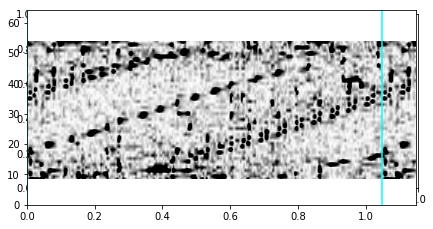

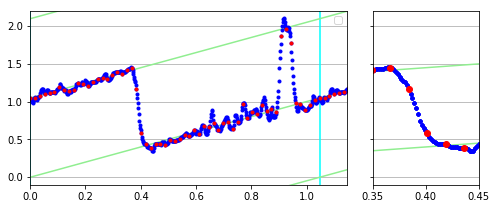

In [29]:
angleP, valuesP = predict(model4)
angleForEst = np.arange(0, aSym, 2*math.pi/1777) # Don't use the same stepsize as the evaluation set
valuesForEst = pOImage(angleForEst)
angleEst =  angleOfPrediction (valuesP, valuesForEst, angleForEst, maePVector)
valuesP = atan2(valuesP)
gtPOPlot = pOAngleImage(angleP)
errorP = aePAngle(valuesP,gtPOPlot)
print(f"MAE (angle per pixel):{np.nanmean(errorP)}")
print(f"MAE (angle):{np.nanmean(aePAngle(angleP, angleEst))}")
plotError (angleP, errorP, fname='toyexample-model4-error.pdf')
plotAngular (angleP, valuesP[:,32], xlim=(0,aSym+0.1), training=(gtAlpha, gtPOAlpha[:,32]), fname='toyexample-model4-middleline.pdf', zoomlim=(0.35, 0.45))
plotAngular (angleP, angleEst, xlim=(0,aSym+0.1), training=(gtAlpha, gtAlpha), fname='toyexample-model4.pdf')

## Model 5: pO image with symmetry aware loss that enforces consistency

In [30]:
def singleTrain5(doTrain):
    model = encoderDecoderNet (2) # Output as a 2D-vector
    model.compile(loss=maePCVector, optimizer='adam', metrics=[maePCVector])
    if doTrain:
        history = model.fit(imgData, gtPOData, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model5 = multiTrain (singleTrain5)

Loading singleTrain5-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


MAE (angle per pixel):0.007221378710539002
MAE (angle):0.004192247663046776


W0928 10:17:41.056401 140735759434624 legend.py:1289] No handles with labels found to put in legend.
W0928 10:17:41.694846 140735759434624 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

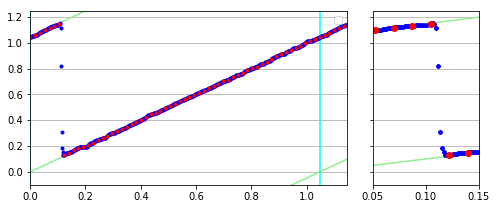

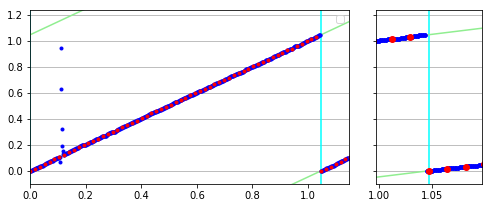

In [31]:
angleP, valuesP = predict(model5)
angleForEst = np.arange(0, aSym, 2*math.pi/1777) # Don't use the same stepweise as the evaluation set
valuesForEst = pOImage(angleForEst)
angleEst =  angleOfPrediction (valuesP, valuesForEst, angleForEst, maePVector)
valuesP = atan2(valuesP)
gtPOPlot = pOAngleImage(angleP)
errorP = aePAngle(valuesP,gtPOPlot)
print(f"MAE (angle per pixel):{np.nanmean(errorP)}")
print(f"MAE (angle):{np.nanmean(aePAngle(angleP, angleEst))}")
plotError(angleP, errorP, fname='toyexample-model5-error.pdf')
plotAngular (angleP, valuesP[:,32], xlim=(0,aSym+0.1), training=(gtAlpha, gtPOAlpha[:,32]), zoomlim=(0.05,0.15), fname='toyexample-model5-middleline.pdf')
plotAngular (angleP, angleEst, xlim=(0,aSym+0.1), training=(gtAlpha, gtAlpha), zoomlim=(aSym-0.05,aSym+0.05), fname='toyexample-model5.pdf')

## Model 6: symmetry aware vector (proposed)

In [32]:
gtPOSVector = pOImage(gtAlpha, angleFactor = nSym) # symmetry aware pO* image

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


In [33]:
def singleTrain6(doTrain):
    model = encoderDecoderNet (2) # Output as a 2D-vector
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    if doTrain:
        history = model.fit(imgData, gtPOSVector, epochs=epochs, batch_size=10, shuffle=True, verbose=0) # validation_data=valData
        return model, history
    else:
        return model, None

model6 = multiTrain(singleTrain6)

Loading singleTrain6-median.h5


/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


MAE (angle per pixel):0.0028709274483689397
MAE (angle):0.000470132318549411


W0928 10:19:32.145586 140735759434624 legend.py:1289] No handles with labels found to put in legend.
W0928 10:19:32.757767 140735759434624 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

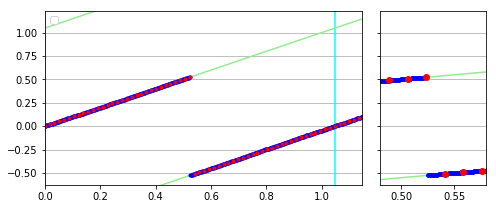

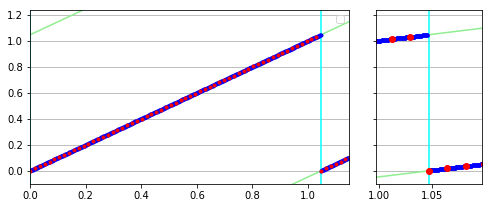

In [34]:
angleP, valuesP = predict(model6)
angleForEst = np.arange(0, aSym, 2*math.pi/1777) # Don't use the same stepweise as the evaluation set
valuesForEst = pOImage(angleForEst, angleFactor = nSym)
angleEst =  angleOfPrediction (valuesP, valuesForEst, angleForEst, mae)
valuesP = atan2(valuesP)/nSym
gtPOPlot = pOAngleImage(angleP)
errorP = aePAngle(valuesP,gtPOPlot)
print(f"MAE (angle per pixel):{np.nanmean(errorP)}")
print(f"MAE (angle):{np.nanmean(aePAngle(angleP, angleEst))}")
plotError (angleP,errorP, fname='toyexample-model6-error.pdf')
plotAngular (angleP, valuesP[:,32], xlim=(0,aSym+0.1), training=(gtAlpha, gtAlpha), zoomlim=(0.48, 0.58), fname='toyexample-model6-middleline.pdf')
plotAngular (angleP, angleEst, xlim=(0,aSym+0.1), training=(gtAlpha, gtAlpha), zoomlim=(aSym-0.05, aSym+0.05), fname='toyexample-model6.pdf')